In [3]:
import Pkg
using Cxx
using Libdl
using FFTW
using PyPlot
include("/Users/gr_1/Documents/IsoFlex/IsoFlex.jl")

Main.IsoFlex

In [4]:
pw = pwd() * "/../src/"
Libdl.dlopen(pw * "liblemur", Libdl.RTLD_GLOBAL)
cxxinclude(pw * "lemur.h")

In [5]:
function set_lemur(maker, nm, var)
    if length(var) > 1
        var = vec(var)
        x = convert(cxxt"double *",pointer(var));
        @cxx maker -> set(pointer(nm), x, length(var))
        
    else
        x = convert(cxxt"double",var);
        try
            @cxx maker -> set(pointer(nm), x)
        catch
            print(string("invalid param", nm))
        end
    end
    return

end

function get_lemur(maker, nm, ny, nx)
    y = @cxx maker -> get(pointer(nm))
    z = unsafe_wrap(Array,pointer(y),ny*nx)
    z = reshape(z,ny,nx)
    return z
end



get_lemur (generic function with 1 method)

In [6]:
mutable struct lemur_obj
    k
    undercapacity
    z
    dx
    dy
    t
    dt
    display
    Udt
    flex
    kd
    m
    n
    bc
    wdt
    firstcall
    u
    udt
    ny
    nx
    deposit
    srho
    drawdt
    l
    ks
    sinkfill
    uselandsed
    maxareasinkfill
    precip
    evaprate
    k_sed
    lemur_obj() = new()
    
end

In [7]:
lemur_params = lemur_obj()

lemur_obj(#undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

In [8]:
AbstractPlotting.inline!(true) 

UndefVarError: UndefVarError: AbstractPlotting not defined

In [9]:
lemur_params.ny = 2000
lemur_params.nx = 2000
lemur_params.z = rand(lemur_params.ny,lemur_params.nx);
lemur_params.display = 1
lemur_params.udt = 100000
lemur_params.flex = 20e3
lemur_params.deposit = false
lemur_params.bc = zeros(lemur_params.ny,lemur_params.nx)
lemur_params.bc[:, 1] .= 0
lemur_params.bc[:, end] .= 0
lemur_params.bc[1, :] .= 1
lemur_params.bc[end, :] .= 0
bcx = lemur_params.bc
lemur_params.z[lemur_params.bc .== 1] .= 0
lemur_params.bc = vec(lemur_params.bc)
lemur_params.k_sed = 1e-6
lemur_params.srho = 2400
lemur_params.udt = 1e5
lemur_params.bc = float(findall(lemur_params.bc .== 1))
lemur_params.k = zeros(lemur_params.ny,lemur_params.nx) .+ 1e-5
lemur_params.firstcall = 1
lemur_params.l = 1
lemur_params.evaprate = 1e-30
lemur_params.maxareasinkfill = 1000000
lemur_params.precip = 1
lemur_params.kd = 1
lemur_params.ks = 0
lemur_params.dt = 2e5
lemur_params.t = 1e6
lemur_params.undercapacity = zeros(lemur_params.ny,lemur_params.nx)
lemur_params.k_sed = lemur_params.k
lemur_params.flex = 20e3
lemur_params.dx = 100
lemur_params.dy = 100
lemur_params.m = .5
lemur_params.n = 1
lemur_params.u = 100000

100000

In [38]:
include("/Users/gr_1/Documents/IsoFlex/IsoFlex.jl")
model = @cxxnew lemur(lemur_params.ny,lemur_params.nx)
for nm = fieldnames(lemur_obj)
    print(string(nm,' '))
    try
        set_lemur(model, string(nm), getfield(lemur_params,nm))
    catch
        print(" error ")
    end
end

k undercapacity z dx dy t dt display Udt  error flex kd m n bc wdt  error firstcall u udt ny nx deposit srho drawdt  error l ks sinkfill  error uselandsed  error maxareasinkfill precip evaprate k_sed t: parameter not founddisplay: parameter not foundflex: parameter not found1u: parameter not foundudt: parameter not foundny: parameter not foundnx: parameter not founddeposit: parameter not foundsrho: parameter not foundk_sed: parameter not found

z280905
273085
  2.575170 seconds (15.68 k allocations: 953.083 MiB, 1.69% gc time)
1
z187958
183918
  2.245002 seconds (2.21 k allocations: 952.420 MiB, 1.29% gc time)
1
z122651
119309
  2.219421 seconds (2.21 k allocations: 952.420 MiB, 2.32% gc time)
1
z79438
77395
  2.167918 seconds (2.21 k allocations: 952.420 MiB, 0.98% gc time)
1
z52927
52300
  2.186131 seconds (2.21 k allocations: 952.420 MiB, 0.59% gc time)
1

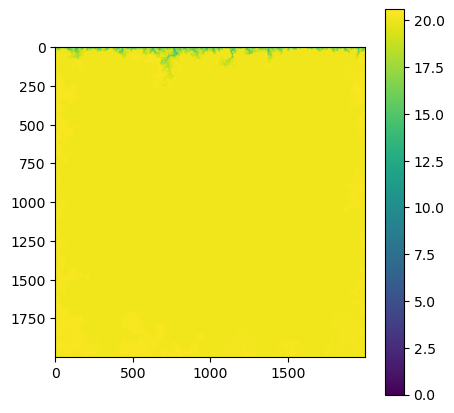

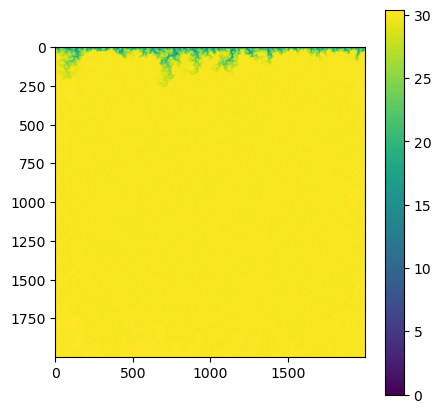

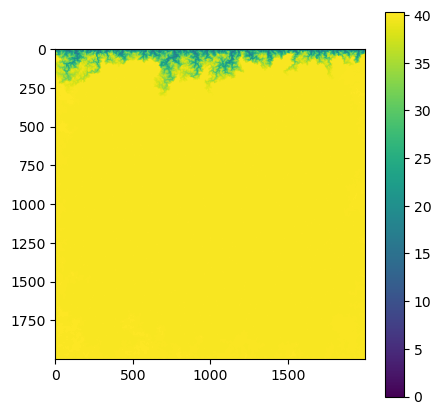

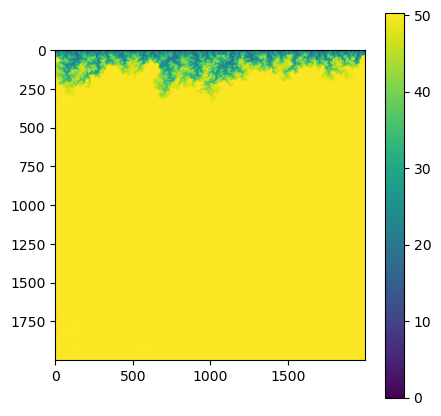

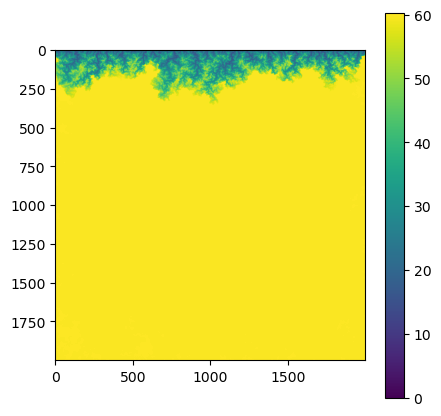


z

In [40]:

function lemur()
z = get_lemur(model, "z", lemur_params.ny, lemur_params.nx)
zi = zeros(size(z))
flex = zeros(size(z))
ero = zeros(size(z))

for i =1:5

    @time begin

    @cxx model -> lakefill()
    @cxx model -> erosion_fluvial()
    z =  copy(get_lemur(model, "z", lemur_params.ny, lemur_params.nx))
    zi = copy(z)

    ero = copy(z .- zi)
    z[bcx .== 0] .+= 10
    IsoFlex.flexural(ero,dx=lemur_params.dx,dy=lemur_params.dy,Te=lemur_params.flex,buffer=200)
    z[bcx .== 0] .+= flex[bcx .== 0]
    set_lemur(model,"z", vec(z))
    end

    subplots(figsize=[5,5])
    imshow(z)
    colorbar()
    println("1")
    
end
end
lemur()

In [41]:
AbstractPlotting.inline!(true)


In [42]:
using AbstractPlotting, WGLMakie
surface(z,colormap = Reverse(:Spectral))

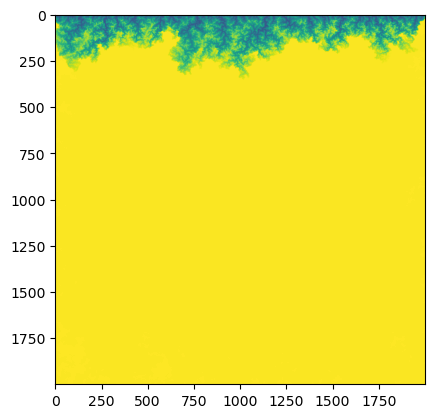

PyObject <matplotlib.image.AxesImage object at 0x7fdf79b4d250>

In [45]:
imshow(z)

In [44]:
z =  copy(get_lemur(model, "z", lemur_params.ny, lemur_params.nx))


z

2000×2000 Array{Float64,2}:
  0.0      0.0      0.0      0.0     …   0.0      0.0      0.0      0.0   
 14.9799  14.9799  10.7006  14.9802     14.9802  10.7634  14.9798  14.9798
 17.6984  17.6984  14.1637  11.7342     16.5525  11.537   16.5421  16.5421
 20.8799  20.8799  17.3637  12.4821     12.7957  13.5884  18.5518  18.5518
 20.2145  20.2145  15.0099  17.341      17.6925  17.1492  17.7143  17.7143
 18.6444  18.6444  18.6477  20.8502  …  20.3362  22.1618  21.3084  21.3084
 21.6916  21.6916  24.0297  21.7936     16.9015  22.3759  26.5244  26.5244
 25.4832  25.4832  27.0446  21.8328     18.3167  22.3349  29.0621  29.0621
 30.6703  30.6703  26.2055  20.7936     23.8557  20.9439  27.7778  27.7778
 30.3398  30.3398  24.6634  25.0368     29.4859  24.9973  25.0275  25.0275
 32.1399  32.1399  30.1059  30.7123  …  31.1144  30.615   28.3952  28.3952
 33.7315  33.7315  31.7913  30.4095     27.2028  33.5431  32.4503  32.4503
 31.7929  31.7929  26.5363  28.0916     26.2626  32.9764  38.0832  38.08